<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting "Greenness" Of Content

_Authors: Joseph Nelson (DC), Kiefer Katovich (SF)_

---


This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender and was made available [here](https://www.kaggle.com/c/stumbleupon/download/train.tsv)

A description of the columns is below

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonLinkRatio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonLinkRatio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonLinkRatio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonLinkRatio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
%matplotlib inline

# set max printout options for pandas:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

### 1. Load the data
- Note it is a `.tsv` file and has a tab separator instead of comma.
- Clean the `is_news` column.
- Make two new columns, `title` and `body`, from the `boilerplate` column.

> **Note:** The `boilerplate` column is in json dictionary format. You can use the `json.loads()` function from the `json` module to convert this into a python dictionary.

In [2]:
evergreen_tsv = '../../data/evergreen_sites.tsv'

In [3]:
data = pd.read_csv(evergreen_tsv, sep='\t', na_values={'is_news' : '?'}).fillna(0)

# Extract the title and body from the boilerplate JSON text
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

### 2. What are 'evergreen' sites?
- These are websites that always relevant like recipes or reviews (as opposed to current events).
- Stored as a binary indicator in the `label` column.
- Look at some examples.

In [4]:
data[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


### 3. Does being a news site affect green-ness?

**3.A Investigate with plots/EDA.**

            label
is_news          
0.0      0.507562
1.0      0.516916


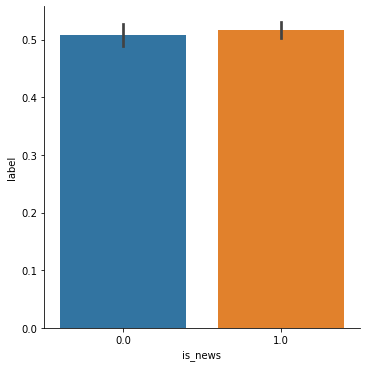

In [32]:
print((data.groupby('is_news')[['label']].mean()))
sns.catplot(x='is_news', y='label', data=data, kind='bar');

**3.B Test the hypothesis with cross validation and logistic regression**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [41]:
# split into X and y
X = data[['is_news']]
y = data['label']
# instantiate estimator
logr = LogisticRegression()
# run cross validation 
cross_validate(logr,X,y)['test_score']

array([0.51318458, 0.51318458, 0.47734956, 0.51318458, 0.51386072])

**3.C Interpret the results of your model.**

In [8]:
# The effect of being a news site on evergreen status is insignificant.
# More formally, we would accept the null hypothesis that news sites and
# non-news sites have equal probability of being evergreen.

### 4. Does the website category affect green-ness?

**4.A Investigate with plots/EDA.**

In [9]:
# ? and unknown should be the same category:
data['alchemy_category'] = data.alchemy_category.map(lambda x: 'unknown' if x == '?' else x)

                       label
alchemy_category            
arts_entertainment  0.371945
business            0.711364
computer_internet   0.246622
culture_politics    0.457726
gaming              0.368421
health              0.573123
law_crime           0.419355
recreation          0.684296
religion            0.416667
science_technology  0.456747
sports              0.205263
unknown             0.501704
weather             0.000000


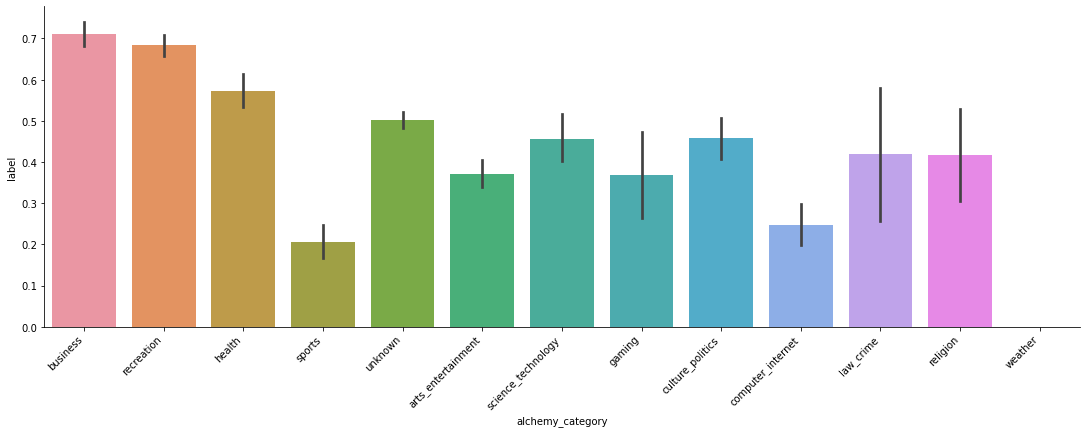

In [34]:
print((data.groupby('alchemy_category')[['label']].mean()))

sns.catplot(x='alchemy_category', y='label', 
               data=data, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right');


**4.B Test the hypothesis with a logistic regression.**

In [46]:
# split into X and y
X = pd.get_dummies(data[['alchemy_category']],drop_first=True)
# run cross validation 
cross_validate(logr,X,y)['test_score']

array([0.60851927, 0.60513861, 0.59770115, 0.59567275, 0.61460446])

**4.C Fit a logistic regression and intepret the results of your model**

In [54]:
logr.fit(X,y)
pd.DataFrame(logr.coef_,columns=X.columns).T.reset_index().rename(columns={'index':'feature',0:'coef'}).sort_values(
    'coef',ascending=False)

,feature,coef
0,alchemy_category_business,1.405644
6,alchemy_category_recreation,1.280120
4,alchemy_category_health,0.799514
10,alchemy_category_unknown,0.517299
2,alchemy_category_culture_politics,0.337780
8,alchemy_category_science_technology,0.333299
7,alchemy_category_religion,0.165506
5,alchemy_category_law_crime,0.164592
3,alchemy_category_gaming,-0.026524
1,alchemy_category_computer_internet,-0.594780


In [12]:
# Many of the categories appear to have a significant effect on the likelihood of evergreen
# status. Note that I have set the reference category to be unknown. This is wrapped into
# the intercept term. These categories must be interpreted as significantly different from
# unknown or not.

# Positive predictors of evergreen vs. unknown:
# 1. Business
# 2. Health
# 3. Recreation

# Negative predictors of evergreen vs. unkown:
# 1. Arts and entertainment
# 2. Computer and internet
# 3. Gaming
# 4. Sports

# The rest of the categories are not significantly different than the unkown category
# in their probability of being evergreen or not.

### 5. Does the image ratio affect green-ness?

**5.A Investigate with plots/EDA.**

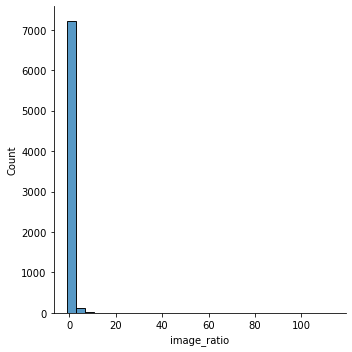

In [57]:
sns.displot(data.image_ratio, bins=30, kde=False)

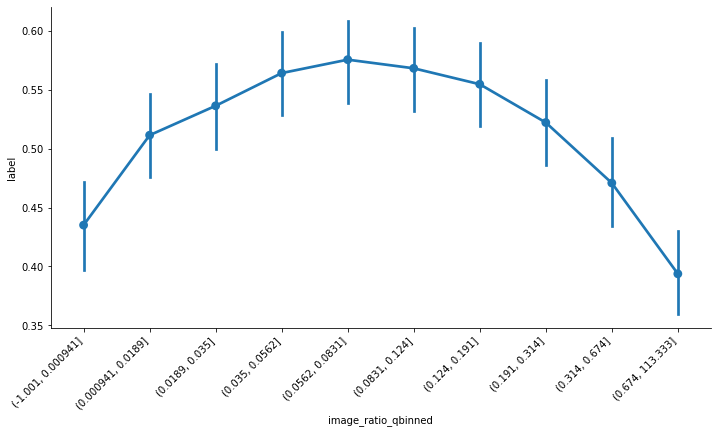

In [74]:
# qcut can divide things up by quantile - in this case into 10 bins
data['image_ratio_qbinned'] = pd.qcut(data['image_ratio'], 10, duplicates='drop')

sns.catplot(x='image_ratio_qbinned', y='label', data=data, aspect=2,kind='point').set_xticklabels(rotation=45, 
                                                                                  horizontalalignment='right');

**5.B Test the hypothesis with cross validation and logistic regression**

> **Note**: It is worth thinking about how to best represent this variable. It may not be wise to input the image ratio as-is.

In [79]:
# split into X and y
X = pd.get_dummies(data[['image_ratio_qbinned']],drop_first=True)
# run cross validation 
logr = LogisticRegression()
#
cross_validate(logr,X,y)['test_score']

array([0.54090602, 0.52738337, 0.52129817, 0.54022989, 0.53414469])

### 6. Fit a logistic regression with multiple predictors.
- The choice of predictors is up to you. Test features you think may be valuable to predict evergreen status.
- Do any EDA you may need.
- Interpret the coefficients of the model.

> **Tip:** [This pdf is very useful for an overview of interpreting logistic regression coefficients.](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf)

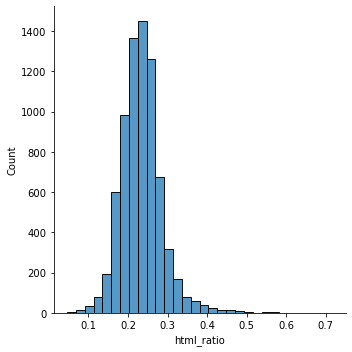

In [89]:
# look at the distribution of html_ratio
sns.displot(data.html_ratio, bins=30, kde=False);

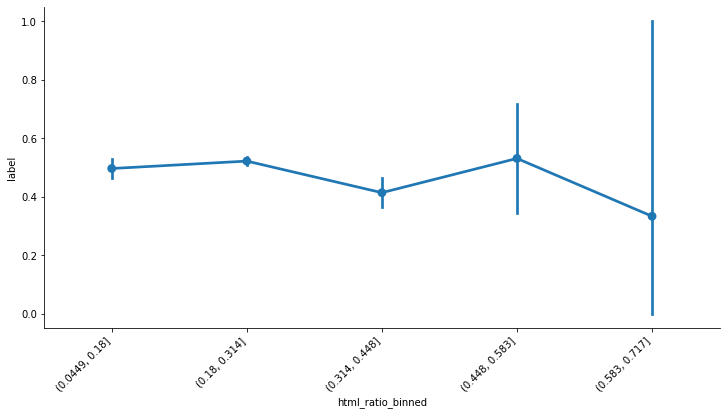

In [91]:
# cut can divide things up into linear bins - in this case into 5 bins
data['html_ratio_binned'] = pd.cut(data['html_ratio'], 5)
sns.catplot(x='html_ratio_binned',y='label', data=data, aspect=2,kind='point').set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right')

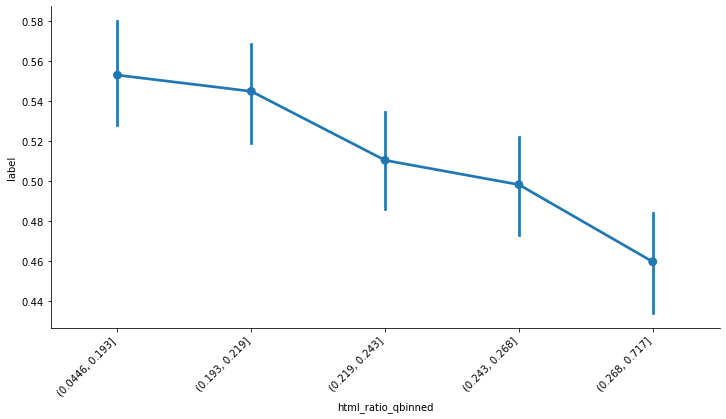

In [94]:
# cut can divide things up into linear bins - in this case into 5 bins
data['html_ratio_qbinned'] = pd.qcut(data['html_ratio'], 5)
sns.catplot(x='html_ratio_qbinned', y='label', data=data, aspect=2,kind='point').set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right');

In [96]:
import scipy.stats as stats
data['html_ratio_pctl'] = data.html_ratio.map(lambda x: stats.percentileofscore(data.html_ratio.values, x))

In [25]:
# You can see scipy puts percentiles from 0-100: important for interpreting coefs
data.html_ratio_pctl.head()

0    63.029074
1    26.747803
2    46.085193
3    78.417850
4    48.275862
Name: html_ratio_pctl, dtype: float64

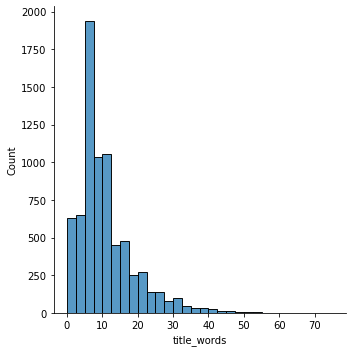

In [97]:
def title_len(x):
    try:
        return len(x.split())
    except:
        return 0.

# calculate the number of words in the title and plot distribution
data['title_words'] = data.title.map(title_len)
sns.displot(data.title_words, bins=30, kde=False);

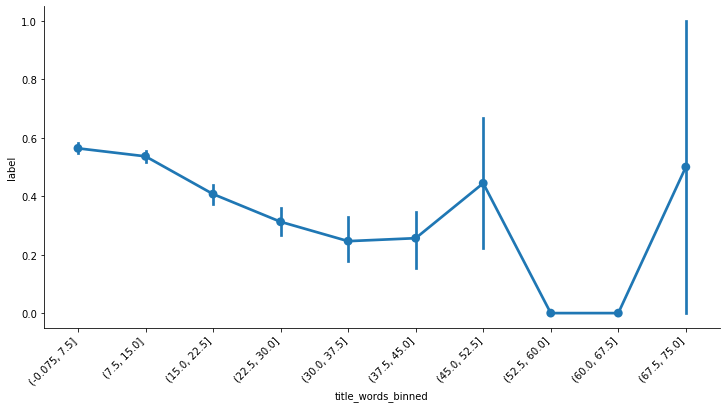

In [98]:
data['title_words_binned'] = pd.cut(data['title_words'], 10)

sns.catplot(x='title_words_binned', y='label', data=data, aspect=2,kind='point').set_xticklabels(rotation=45, 
                                                                                 horizontalalignment='right');

In [99]:
# Build a model with the image ratio percentile, html ratio, and title length
X = data[['image_ratio_pctl','html_ratio_pctl','title_words']]
logr = LogisticRegression()
logr.fit(X,y)
logr.score(X,y)

0.5879648411088574

In [107]:
# coefs are expressed in log odds
coef_df = pd.DataFrame(logr.coef_,columns=X.columns)
coef_df


,image_ratio_pctl,html_ratio_pctl,title_words
0,-0.003115,-0.006641,-0.037585


In [165]:
# iterate through coefs
for i in range(0,3):
    # multiply by 1 unit and get change in proba
    logodds = logr.coef_[0][i]*1#+logr.intercept_[0]
    odds = np.exp(logodds)
    prob = odds/(1+odds)
    # .5 the probability if logodds = 0
    print('change in probability with 1 unit increase in '+X.columns[i]+' : ',round(prob-0.5,5))

change in probability with 1 unit increase in image_ratio_pctl :  -0.00156
change in probability with 1 unit increase in html_ratio_pctl :  -0.00332
change in probability with 1 unit increase in title_words :  -0.01878


In [30]:
# interpret them as probabilities
# 1. for a 1 percentile increase in image_ratio, there is a -0.00078 decrease in the probabilty of evergreen
# 2. for a 1 percentile increase in html_ratio, there is a -0.00166 decrease in the probabilty of evergreen
# 3. for a 1 word increase in the length of the title, there is a -0.0094 decrease in the probabilty of evergreen

In [168]:
from sklearn.metrics import confusion_matrix
conmat = confusion_matrix(y, y_pred)
confusion = pd.DataFrame(conmat, index=['Actual: 0','Actual: 1'],
                         columns=['Pred: 0','Pred: 1'])
confusion


,Pred: 0,Pred: 1
Actual: 0,1700,1899
Actual: 1,1148,2648


$$\frac{True Positives}{True Positives + False Positives}$$

In [170]:
# precision
TP = 2648
FP = 1899
precision = TP/(TP+FP)
precision

0.5823619969210468

$$\frac{True Positives}{True Positives + False Negatives}$$

In [171]:
# recall
FN = 1148
recall = TP/(TP+FN)
recall

0.6975763962065332

In [175]:
from sklearn.metrics import precision_recall_fscore_support
# fscore is the third element and we want the fscore for true positives 
precision_recall_fscore_support(y,y_pred)[2][1]

0.6347836509648808

In [167]:
from sklearn.metrics import classification_report

# use the predict function to create an array of predictions for your predictors and assign it to y_pred
y_pred = logr.predict(X)
# print a classification report for your y and and y_pred values
print(classification_report(y,y_pred,))

              precision    recall  f1-score   support

           0       0.60      0.47      0.53      3599
           1       0.58      0.70      0.63      3796

    accuracy                           0.59      7395
   macro avg       0.59      0.58      0.58      7395
weighted avg       0.59      0.59      0.58      7395

